In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from keras.models import Sequential
from keras.layers import LSTM, Dense, SimpleRNN, Dropout
from sklearn.metrics import mean_squared_error
from keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2


In [22]:
df = pd.read_csv(r"C:/Users/varun/OneDrive/Documents/Guvi/Final Project Guvi/AAPL.csv")
df.head

df.isnull().sum()

# Handling missing values 
df_columns = ['Open','High','Low','Close','Adj Close']
df[df_columns] = df[df_columns].fillna(method='ffill')
df['Volume'] = df['Volume'].fillna(0)

# Checking missing values after handling them
df.isnull().sum()

# Changing the Dtype of 'Date' column
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace = True)

numeric_col = ['Open','High','Low','Close','Adj Close','Volume']
df[numeric_col] = df[numeric_col].astype(float)

C:\Users\varun\AppData\Local\Temp\ipykernel_31968\1492093746.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[df_columns] = df[df_columns].fillna(method='ffill')


In [23]:
target_col = 'Adj Close'
target_data = df[[target_col]].values

# Data Normalization
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(target_data)

# Get dates for plotting
dates = df.index

# Splitting data (Train on 2018, Test on 2019)
train_mask = df.index.year == 2018
test_mask = df.index.year == 2019

train_data = scaled_data[train_mask]
test_data = scaled_data[test_mask]

# Get corresponding dates
train_dates = dates[train_mask]
test_dates = dates[test_mask]

In [24]:
def create_sequence(data, dates, seq_length):
    X, y, seq_dates = [], [], []
    for i in range(len(data) - seq_length - 10):  # 10 for max prediction
        X.append(data[i : i + seq_length])
        y.append([
            data[i + seq_length],
            data[i + seq_length + 4],
            data[i + seq_length + 9]
        ])
        # Store the prediction date (date at end of sequence + prediction horizon)
        seq_dates.append(dates[i + seq_length])
    return np.array(X), np.array(y), np.array(seq_dates)

seq_length = 100  # using 100 days history
X_train, y_train, train_pred_dates = create_sequence(train_data, train_dates, seq_length)
X_test, y_test, test_pred_dates = create_sequence(test_data, test_dates, seq_length)

In [25]:
# 1. Build Models 
def build_rnn_model(input_shape):
    model = Sequential([
        SimpleRNN(64, return_sequences=True, input_shape=input_shape),
        Dropout(0.3),
        SimpleRNN(32),
        Dropout(0.3),
        Dense(3)  # 3 outputs for 1-day, 5-day, 10-day predictions
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model(input_shape):
    model = Sequential([
        LSTM(64, 
             return_sequences=True, 
             input_shape=input_shape,
             kernel_regularizer=l2(0.01)),  
        Dropout(0.2),
        LSTM(32, 
             kernel_regularizer=l2(0.01)),  
        Dropout(0.2),
        Dense(3)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [26]:
# 2. Train Models with improved visualization 
def train_and_visualize(model, X_train, y_train, X_test, y_test, model_name):
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_test, y_test),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=1
    )
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} Training History', fontsize=14)
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('MSE Loss', fontsize=12)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()
    
    return model

In [27]:
# 3. Evaluation with dates and improved visualization
def evaluate_model(model, X_test, y_test, test_dates, scaler, model_name):
    y_pred = model.predict(X_test)
    
    # Reshape for inverse transform
    y_test_flat = y_test.reshape(-1, 1)
    y_pred_flat = y_pred.reshape(-1, 1)
    
    # Inverse scaling
    y_test_actual = scaler.inverse_transform(y_test_flat).reshape(y_test.shape)
    y_pred_actual = scaler.inverse_transform(y_pred_flat).reshape(y_pred.shape)
    
    # Prepare dates for each horizon
    date_1day = test_dates  # For 1-day prediction
    date_5day = test_dates  # For 5-day prediction (same dates, different predictions)
    date_10day = test_dates  # For 10-day prediction
    
    # Evaluate each horizon
    horizons = ['1-Day', '5-Day', '10-Day']
    date_list = [date_1day, date_5day, date_10day]
    
    all_results = []
    
    for i, (horizon, dates) in enumerate(zip(horizons, date_list)):
        actual = y_test_actual[:,i]
        pred = y_pred_actual[:,i]
        
        mse = mean_squared_error(actual, pred)
        print(f"{model_name} - {horizon} MSE: {mse:.4f}")
        
        # Plot predictions vs actual with dates
        plt.figure(figsize=(14, 6))
        plt.plot(dates, actual, label='Actual Price', linewidth=2)
        plt.plot(dates, pred, label='Predicted Price', linestyle='--')
        plt.title(f'{model_name} - {horizon} Price Prediction (2019 Test Data)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Adjusted Close Price ($)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        all_results.append((dates, actual, pred))
    
    return all_results

In [28]:
# 4. Comparison function (unchanged)
def plot_comparison(rnn_results, lstm_results):
    horizons = ['1-Day', '5-Day', '10-Day']
    
    for i, horizon in enumerate(horizons):
        rnn_dates, rnn_actual, rnn_pred = rnn_results[i]
        lstm_dates, lstm_actual, lstm_pred = lstm_results[i]
        
        plt.figure(figsize=(16, 6))
        plt.plot(rnn_dates, rnn_actual, label='Actual Price', color='black', linewidth=2)
        plt.plot(rnn_dates, rnn_pred, label='RNN Predicted', linestyle='--', color='blue')
        plt.plot(lstm_dates, lstm_pred, label='LSTM Predicted', linestyle='--', color='red')
        
        plt.title(f'Model Comparison - {horizon} Price Prediction (2019 Test Data)', fontsize=14)
        plt.xlabel('Date', fontsize=12)
        plt.ylabel('Adjusted Close Price ($)', fontsize=12)
        plt.legend(fontsize=12)
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


d:\Anaconda\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 13s 299ms/step - loss: 1.0145 - val_loss: 0.1655
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.4093 - val_loss: 0.0164
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.2616 - val_loss: 0.0755
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - loss: 0.2594 - val_loss: 0.0190
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.2152 - val_loss: 0.0384
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.2111 - val_loss: 0.0103
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.1483 - val_loss: 0.0170
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1481 - val_loss: 0.0047
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.1414 - val_loss: 0.0054
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - loss: 0.1242 - val_loss: 0.0041
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 180ms/step - loss: 0.1009 - val_loss: 0.0045
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - lo

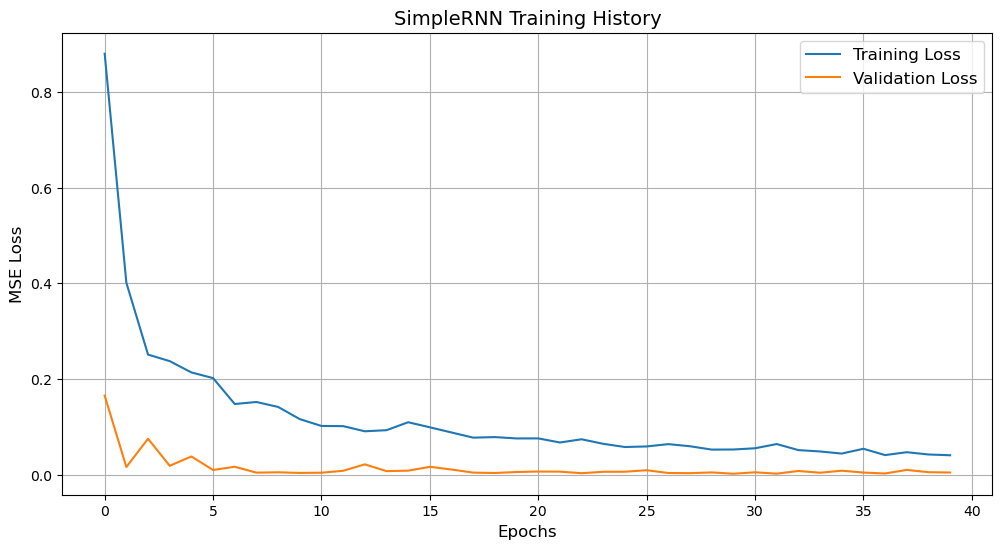


Training LSTM...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - loss: 1.2698 - val_loss: 1.0641
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 0.9408 - val_loss: 0.7673
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.7997 - val_loss: 0.7091
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.7274 - val_loss: 0.6862
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.6800 - val_loss: 0.6290
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 0.6222 - val_loss: 0.5722
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5794 - val_loss: 0.5276
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 0.5309 - val_loss: 0.4921
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.4956 - val_loss: 0.4581
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.4580 - val_loss: 0.4184
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.4231 - val_loss: 0.3863
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - lo

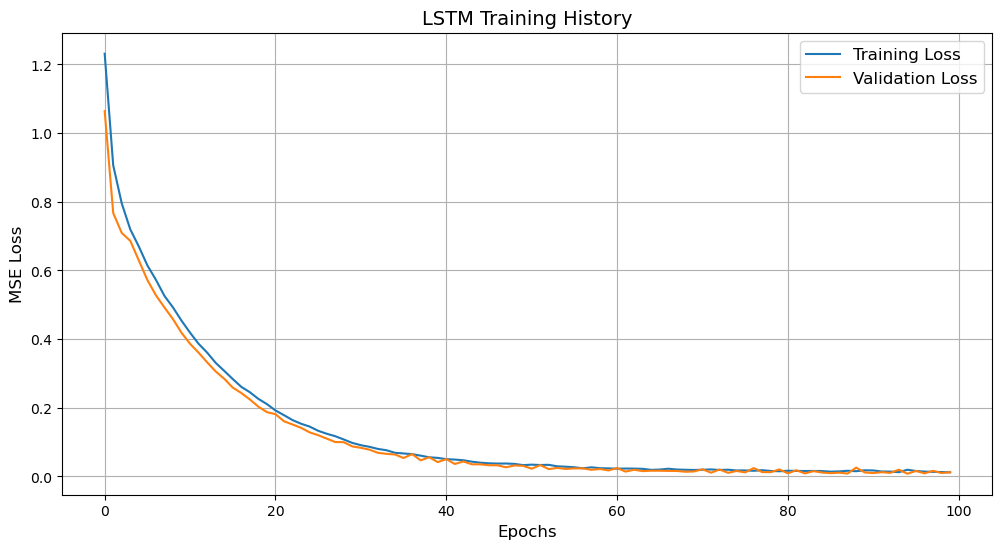


RNN Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step
RNN - 1-Day MSE: 106.6204


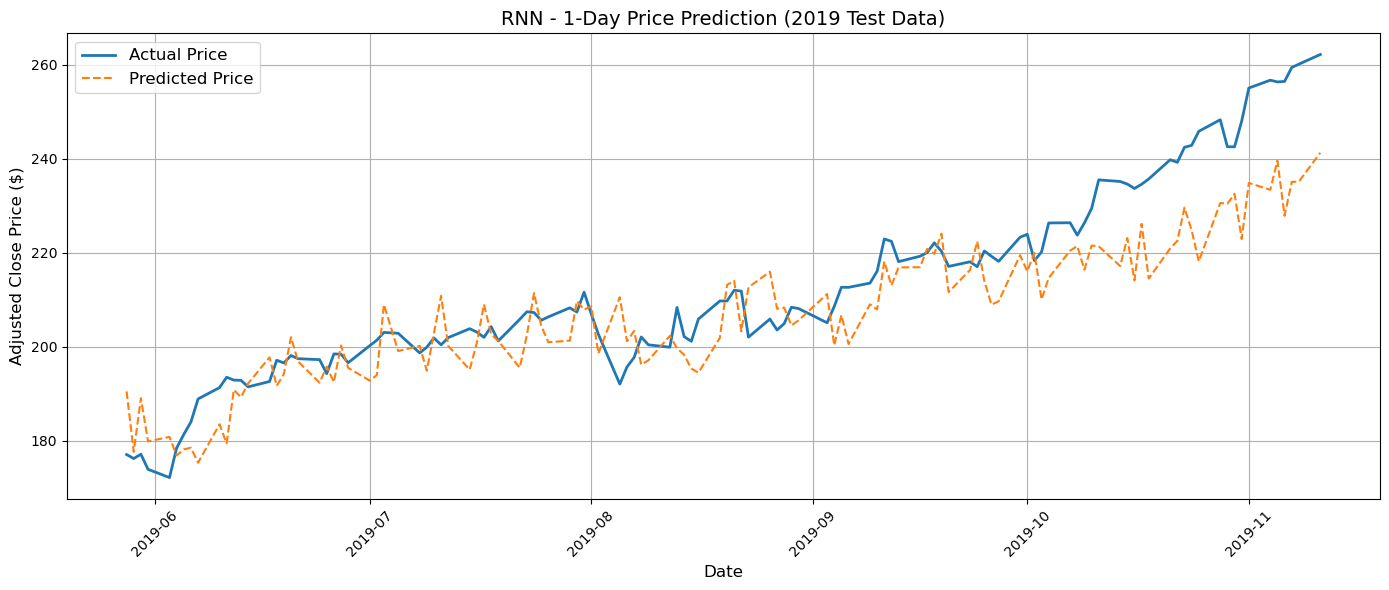

RNN - 5-Day MSE: 241.5618


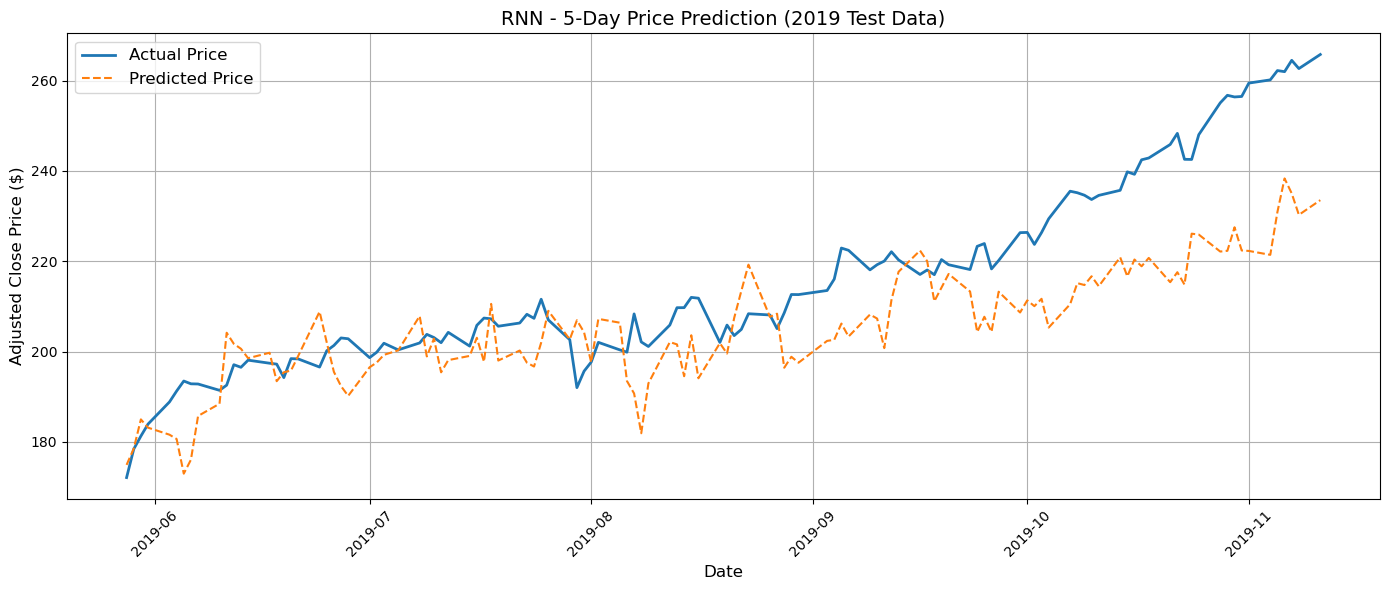

RNN - 10-Day MSE: 170.7891


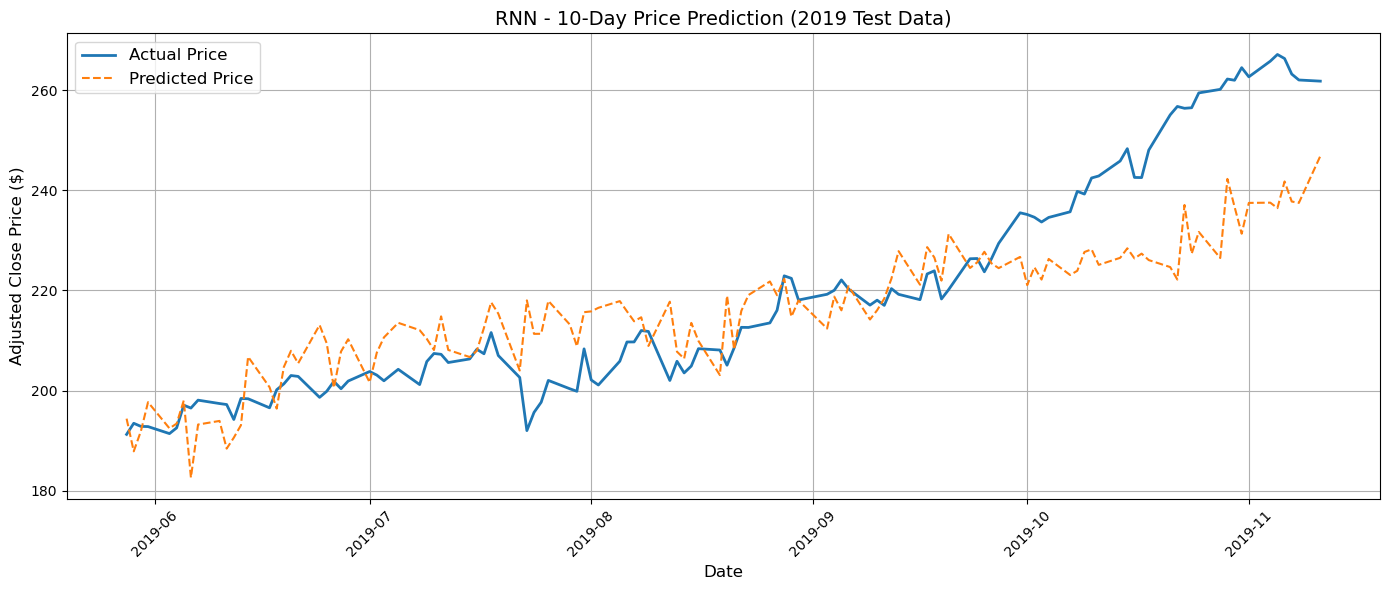


LSTM Evaluation:
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step
LSTM - 1-Day MSE: 190.5498


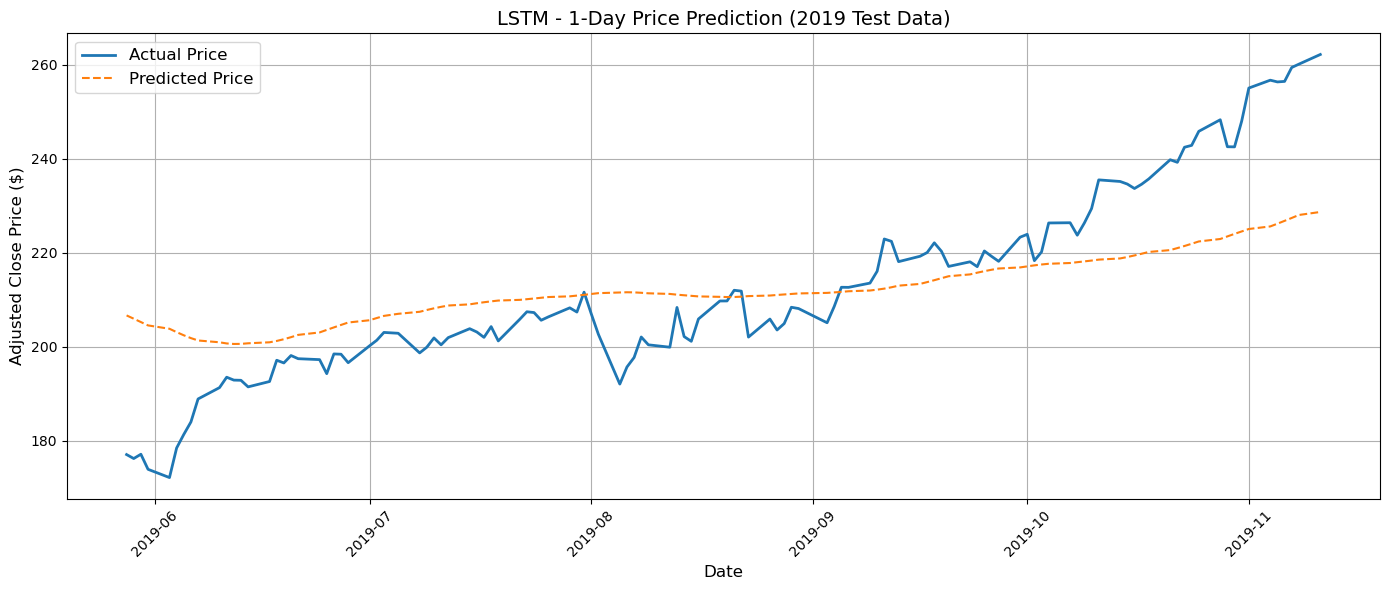

LSTM - 5-Day MSE: 253.0857


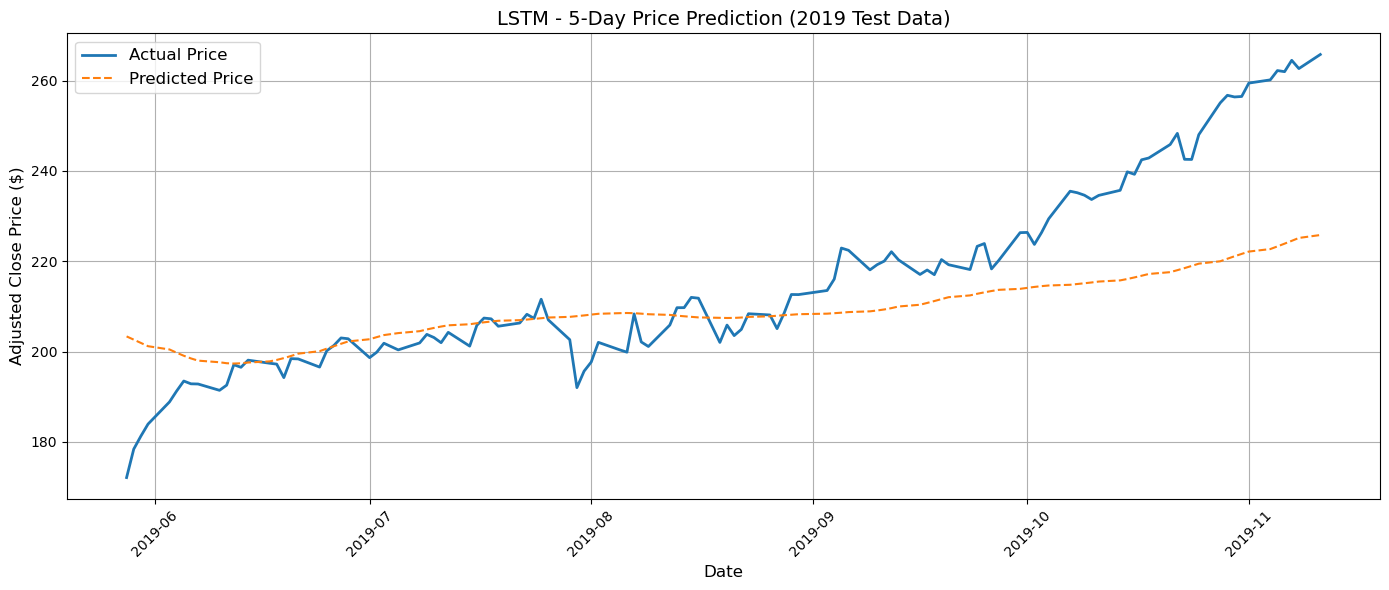

LSTM - 10-Day MSE: 432.5655


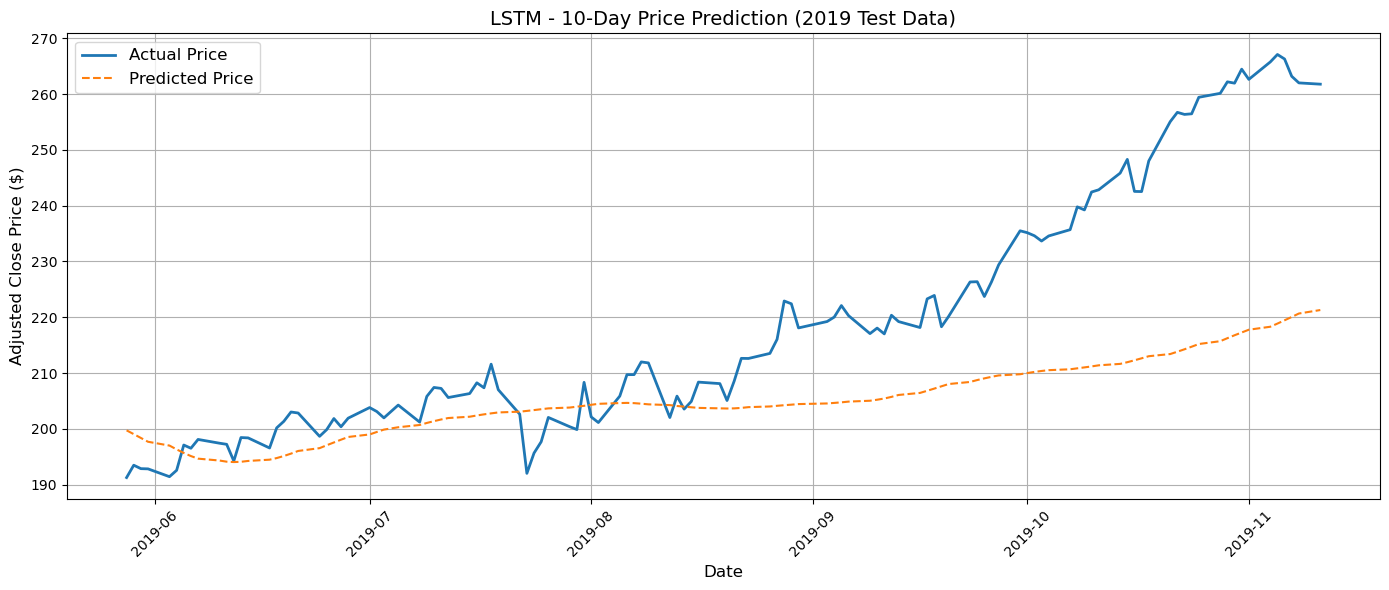


Model Comparison:


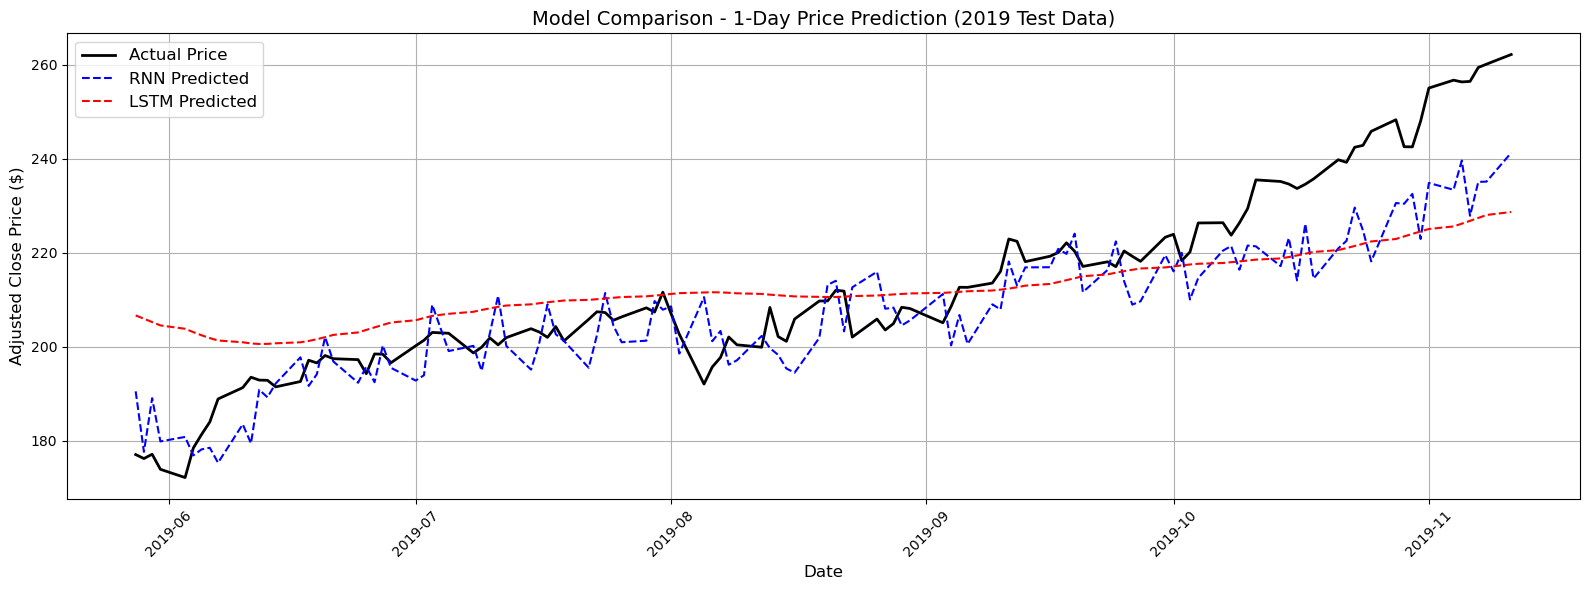

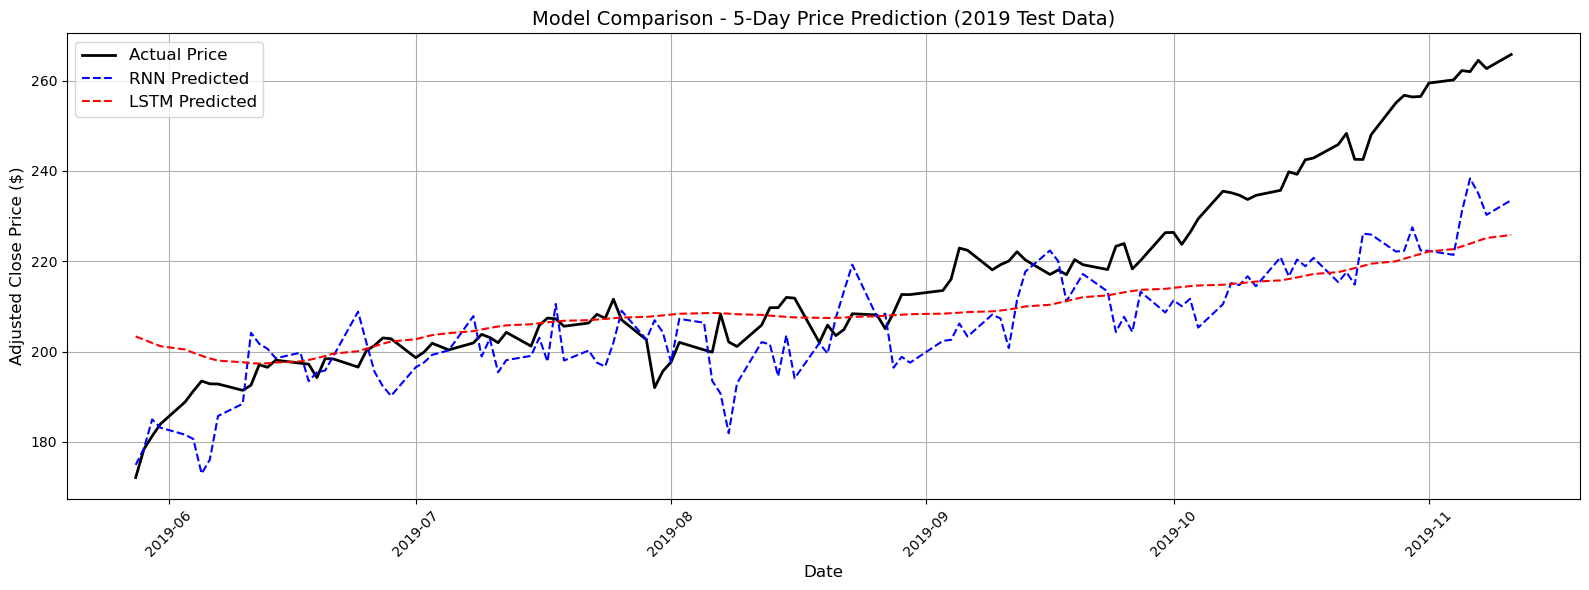

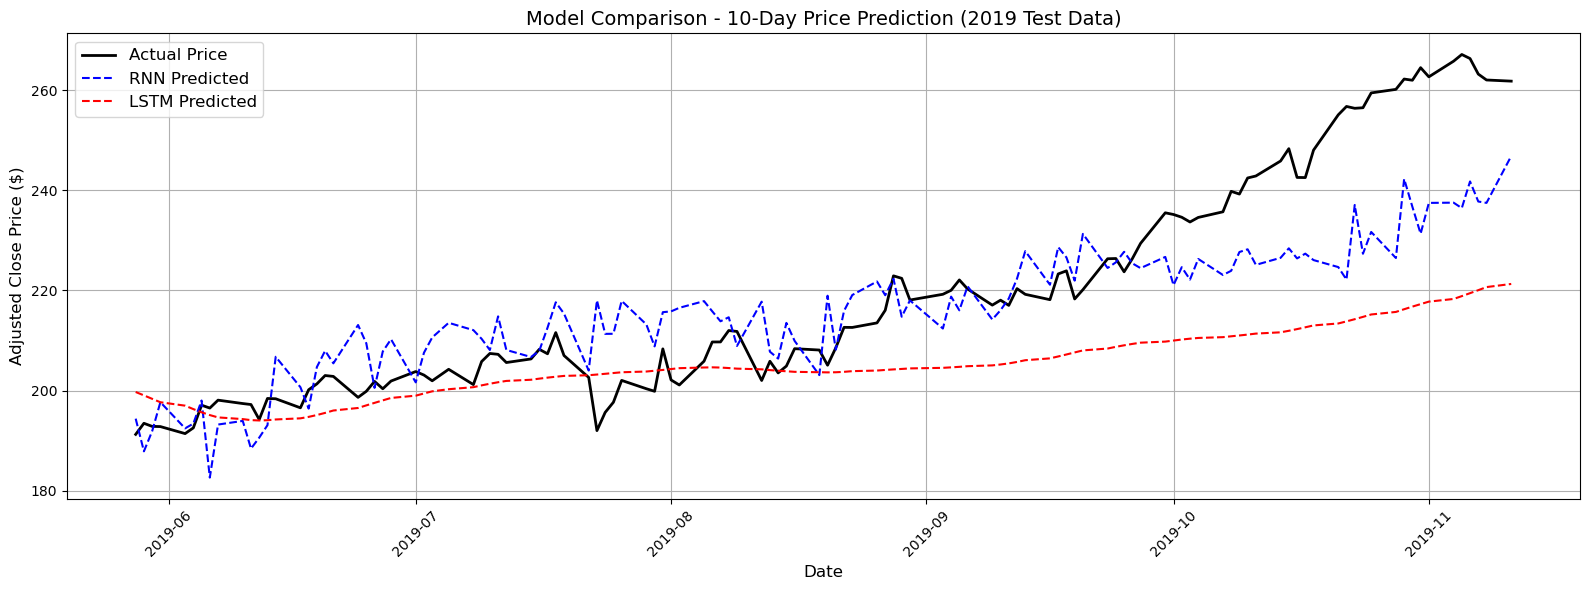

Models saved successfully!


In [29]:
# Main execution
if __name__ == "__main__":
    # Initialize models
    input_shape = (X_train.shape[1], X_train.shape[2])  # (seq_length=100, features=1)
    
    rnn_model = build_rnn_model(input_shape)
    lstm_model = build_lstm_model(input_shape)
    
    # Train and visualize
    print("Training RNN...")
    rnn_model = train_and_visualize(rnn_model, X_train, y_train, X_test, y_test, "SimpleRNN")
    
    print("\nTraining LSTM...")
    lstm_model = train_and_visualize(lstm_model, X_train, y_train, X_test, y_test, "LSTM")
    
    # Evaluate models
    print("\nRNN Evaluation:")
    rnn_results = evaluate_model(rnn_model, X_test, y_test, test_pred_dates, scaler, "RNN")
    
    print("\nLSTM Evaluation:")
    lstm_results = evaluate_model(lstm_model, X_test, y_test, test_pred_dates, scaler, "LSTM")
    
    # Plot comparison
    print("\nModel Comparison:")
    plot_comparison(rnn_results, lstm_results)
    
    # Save Models
    rnn_model.save('simple_rnn_model_100day.h5')
    lstm_model.save('lstm_model_100day.h5')
    print("Models saved successfully!")